In [ ]:
from numba import cffi_support, types, jit
from cffi import FFI
%matplotlib inline
from matplotlib import pyplot as plt

## Create an out-of-line module wrapping Intel's Vector Math Library

CFFI can't handle preprocessor directives, a few of which are used in the MKL headers.

So we use a trick: let's include the header and run the preprocessor over it, to get out something with no preprocessor directives in it that CFFI can read:

In [2]:
%%writefile vml_cffi.h
#include "mkl_vml.h"

Overwriting vml_cffi.h


In [3]:
!gcc -E vml_cffi.h -o vml_functions.h -I/home/pydata/anaconda3/envs/pydata/include

Now let's read in the source (ignoring any lines that begin with a #):

In [5]:
lines = []
with open('vml_functions.h') as f:
    for line in f:
        if line[0] != '#':
            lines.append(line)
source = "".join(lines)
#print(source)

Now we have the source available, we can make a CFFI module with it:

In [6]:
ffi = FFI()
ffi.set_source('vmlfuncs', source, libraries=['mkl_rt'])
ffi.cdef(source)
ffi.compile()

'/home/pydata/work/adp_demo/vmlfuncs.cpython-35m-x86_64-linux-gnu.so'

Now we can import the generated module:

In [8]:
import vmlfuncs
# The lib member contains all the functions from the header:
vml = vmlfuncs.lib
# The ffi member contains useful functions for working with the module
ffi = vmlfuncs.ffi

Instantly, we can use these functions from Python:

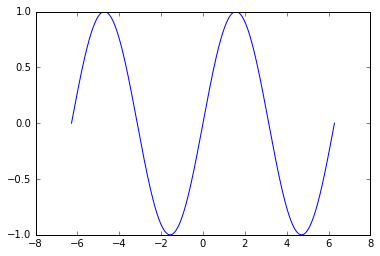

In [9]:
import numpy as np
points = np.linspace(-2 * np.pi, 2 * np.pi, 1000000)
result = np.zeros_like(points)

vml.vdSin(len(points), ffi.from_buffer(points), ffi.from_buffer(result))

plt.plot(points, result)

A performance difference is observed when using VML:

In [10]:
points = np.linspace(-2 * np.pi, 2 * np.pi, 100000000)
result = np.zeros_like(points)

In [11]:
%timeit vml.vdSin(len(points), ffi.from_buffer(points), ffi.from_buffer(result))

1 loop, best of 3: 351 ms per loop


In [12]:
%timeit np.sin(points)

1 loop, best of 3: 2.85 s per loop


## Using the module with Numba

Let's define a jitted function that uses a function from our CFFI-wrapped Vector Maths Library:

In [13]:
vdSin = vmlfuncs.lib.vdSin

@jit(nopython=True)
def vml_sin_from_numba(x):
    out = np.zeros_like(x)
    vdSin(len(x), ffi.from_buffer(x), ffi.from_buffer(out))
    return out

And try to call it:

In [15]:
vml_sin_from_numba(points)

TypingError: Failed at nopython (nopython frontend)
Untyped global name 'vdSin'
File "<ipython-input-13-054750f09307>", line 6

The `TypingError` is because Numba needs to know a little about the type information of an out-of-line FFI module. To give it the required information, we can use Numba's `register_module` function:

In [16]:
cffi_support.register_module(vmlfuncs)

Now let's try again:

In [17]:
vml_sin_from_numba(points)

array([  2.44929360e-16,   1.25663707e-07,   2.51327415e-07, ...,
        -2.51327416e-07,  -1.25663709e-07,  -2.44929360e-16])

## Registering types

Some libraries will accept arrays of structures - for example, MKL represents complex numbers using structs like:

```
struct _MKL_Complex16 {
    double real;
    double imag;
} MKL_Complex16;
```

This coincides with the format of complex arrays in Numpy, which are stored in memory as pairs of real and imaginary parts. Logically we can pass these to VML but Numba needs to understand how to map the Numpy type to the C type.

To give it this information, we can use the `register_type` function that it provides:

In [18]:
cffi_support.register_type(ffi.typeof('struct _MKL_Complex16'), types.complex128)

Now we should be able to use a complex-argument function from a Numba-jitted function:

In [19]:
vzSin = vmlfuncs.lib.vzSin

@jit(nopython=True)
def vml_complex_sin_from_numba(x):
    out = np.zeros_like(x)
    vzSin(len(x), ffi.from_buffer(x), ffi.from_buffer(out))
    return out

In [20]:
c_points = np.linspace(-2 * np.pi, 2 * np.pi, 1000000) + 1j
result = vml_complex_sin_from_numba(c_points)

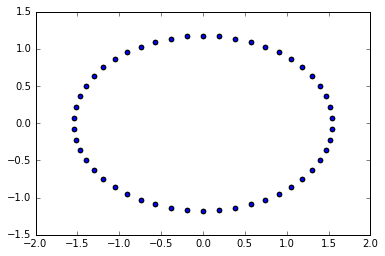

In [21]:
# Plot a subset of points (1000000 is a lot to plot)
plt.scatter(result.real[::10000], result.imag[::10000])